In [ ]:
import pandas as pd
import numpy as np
import os
import bitepy as bp

# Data

### create CSV data files

In [ ]:
# create custom csv market data from raw EPEX data files in UTC time format
# start and end dates dicate which raw files are lodaded.
# output zipped csv of date (d) will have all orders submitted on day d for any product.

parser = bp.Data()
epex_path = "...path/to/raw_epex_files/EPEXSPOT DE/Intraday Continuous/Orders/"
save_path = "...path/to/zipped_csvs/"
parser.parse_market_data("2021-01-01", "2021-01-02", epex_path, save_path, verbose=True)

Currently loading and saving date 2021-01-02 ... : 100%|██████████████| 2/2 [00:31<00:00, 15.96s/it]


Writing CSV data completed.


### create binary data files

In [3]:
# get all zipped csv files we want to make binary data from and save their full path as a list
csv_files = os.listdir(save_path)
csv_files = [f for f in csv_files if f.endswith(".zip")]
csv_files = [save_path + f for f in csv_files]
csv_files.sort()

binary_save_path = "...path/to/binaries/"

# create binary data from csv files
parser.create_bins_from_csv(csv_files, binary_save_path, verbose=True)

Currently saving binary orderbook_2021-01-02.bin ... : 100%|██████████| 2/2 [00:10<00:00,  5.13s/it]


Writing Binaries completed.


# Simulation

### Standard Simulation Run

In [ ]:
params = {
    "storage_max": 10.0, # MWh
    "lin_deg_cost": 4.0, # €/MWh
    "loss_in": 0.95, # injection loss
    "loss_out": 0.95, # withdrawal loss
    "trading_fee": 0.09, # €/MWh
    "num_stor_states": 11,
    "tec_delay": 0, # ms
    "fixed_solve_time": 0, # ms
    "solve_frequency": 1.0, # min
    "withdraw_max": 5.0, # MW, withdrawal from the battery, we sell
    "inject_max": 5.0, # MW, injection into the battery, we buy
}

start_date = pd.Timestamp("2021-01-01 00:00:00", tz="Europe/Berlin")
end_date = pd.Timestamp("2021-02-01 00:00:00", tz="Europe/Berlin")

sim = bp.Simulation(start_date, end_date, **params)
sim.print_parameters()

In [ ]:
ob_path = "...path/to/binaries/"
sim.run(ob_path, verbose=True)

logs = sim.get_logs()

print("\nLog Keys:", logs.keys())

The simulation will iterate over 32 files.


Currently simulating orderbook_2021-01-31.bin ... : 100%|████████████████████████████████| 32/32 [00:40<00:00,  1.27s/%]

Simulation finished.

Log Keys: dict_keys(['decision_record', 'price_record', 'accepted_orders', 'executed_orders', 'forecast_orders', 'killed_orders', 'balancing_orders'])


Total Reward (incl. deg. costs) 6943.11 €.


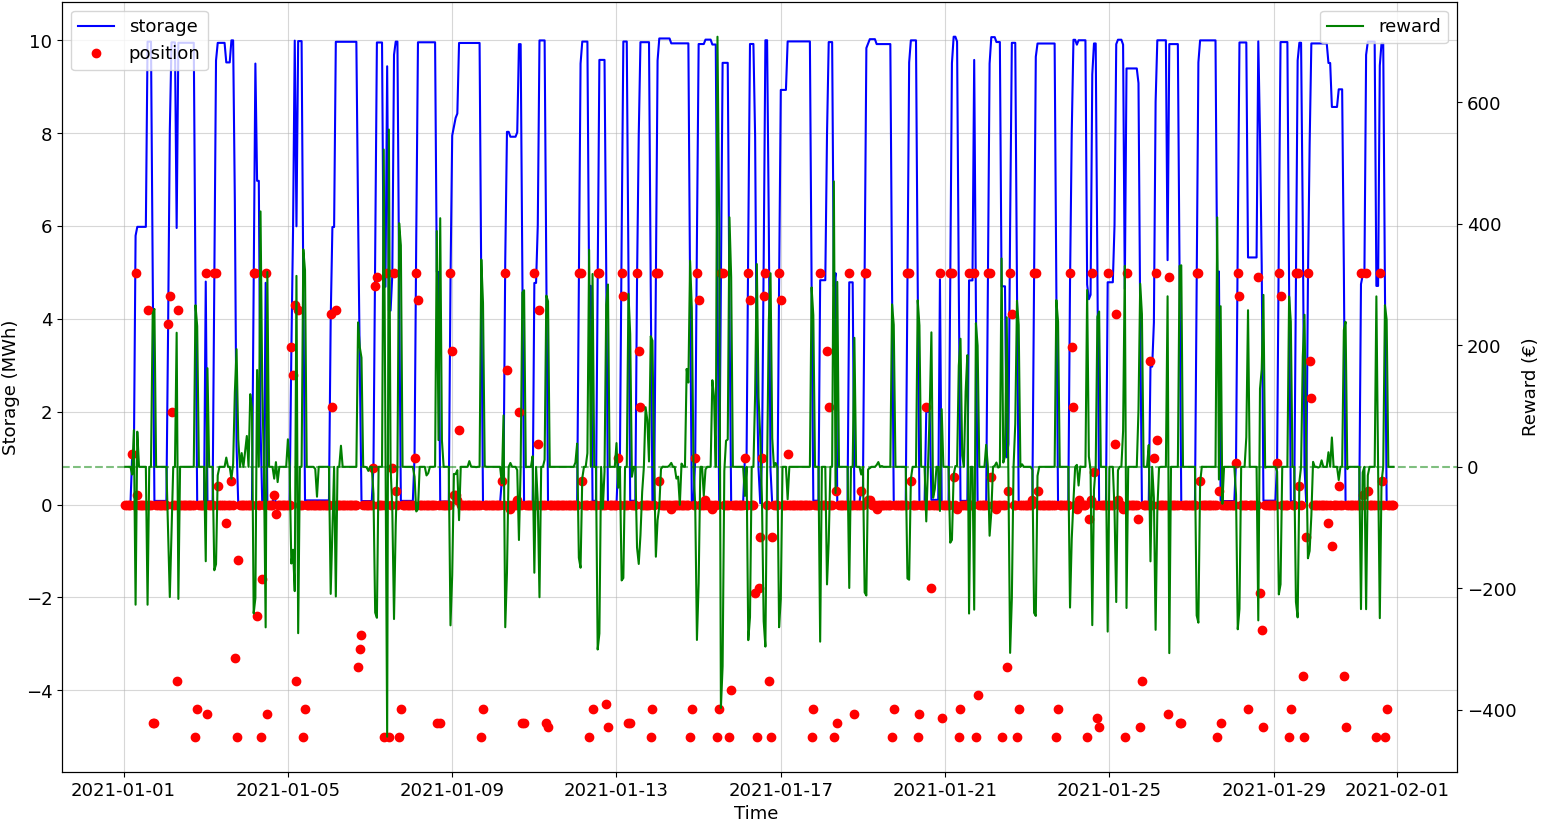

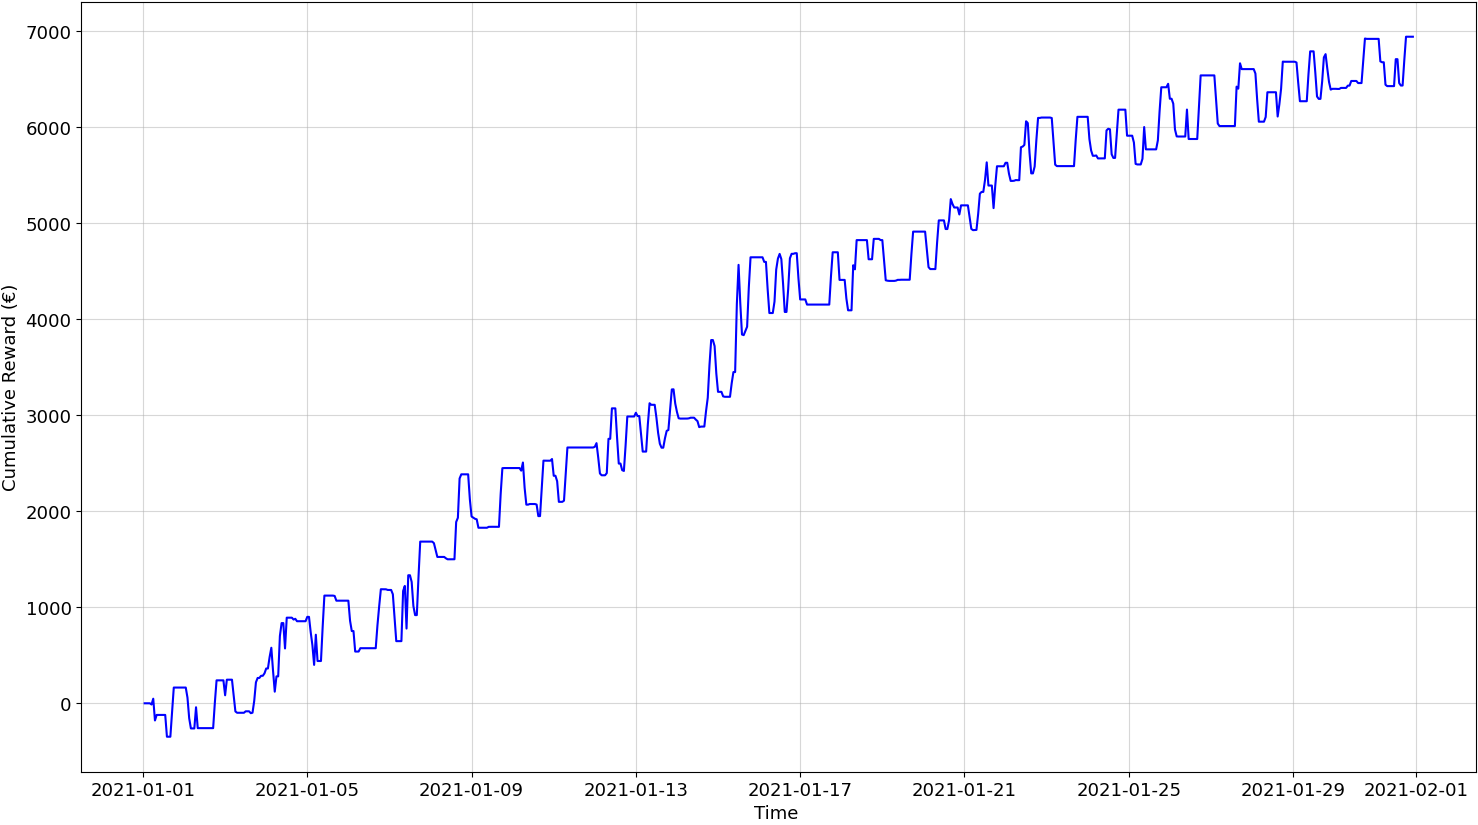

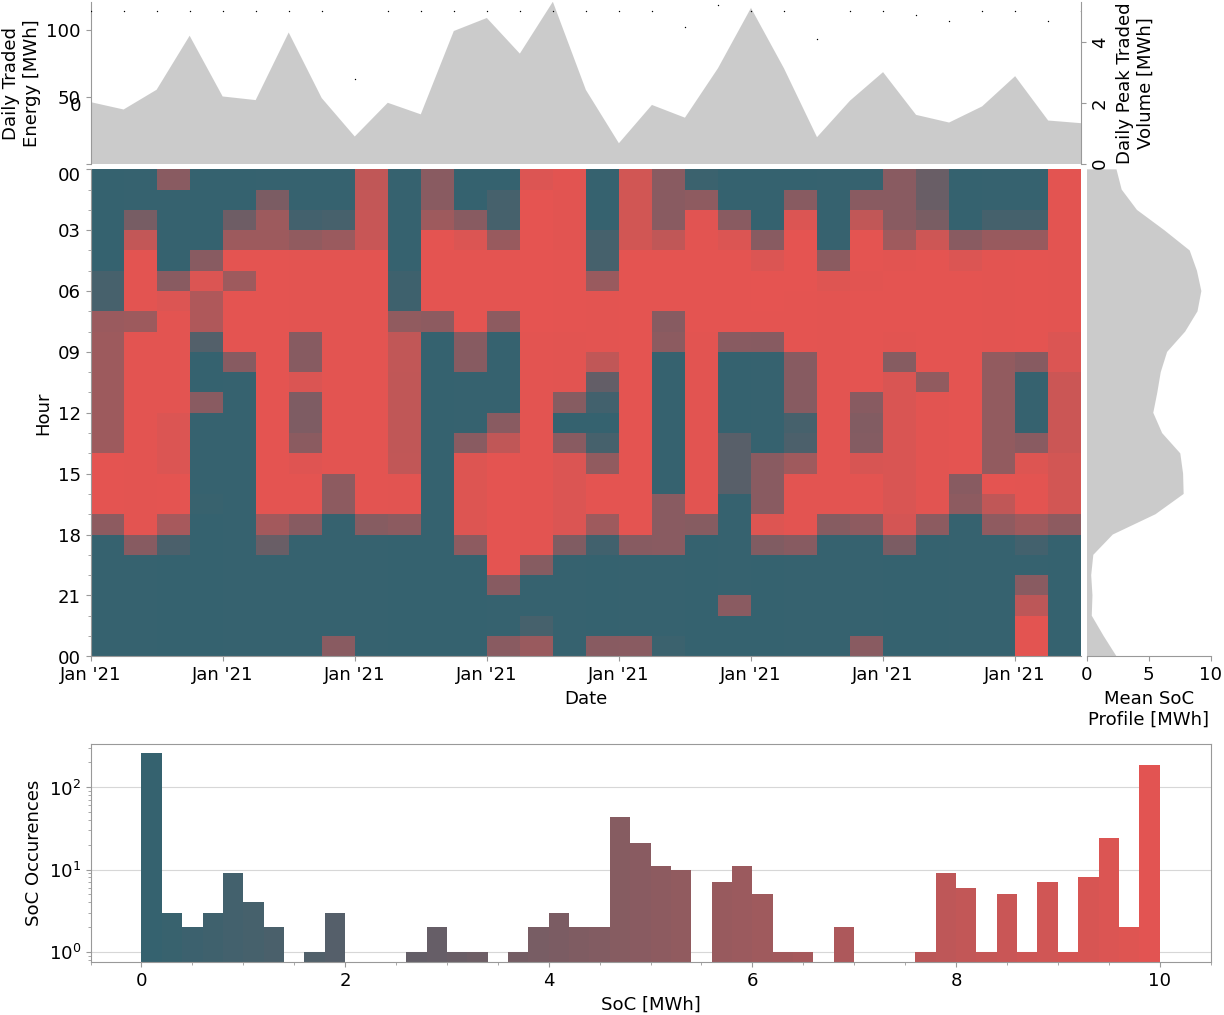

In [ ]:
results = bp.Results(logs)

# display(logs["decision_record"])
# display(logs["price_record"])
# display(logs["accepted_orders"])
# display(logs["executed_orders"])
# display(logs["forecast_orders"])
# display(logs["killed_orders"])
# display(logs["balancing_orders"])

print("Total Reward (incl. deg. costs)", results.get_total_reward(), "€.")
results.plot_decision_chart(0,-1)
results.plot_heatmap()

### export price-vol maps
Here you can export price-volume maps during the runtime of the simulation at a set frequency, for each currently tradable delivery-time and a defined volume-grid. For this, the simulation is run without any battery-trading, s.t. the historic LOB is traversed as is.

Outputs:
- "price_full" corresponds to the full price to be paid/earned buy the trader to buy/sell a certain volume of the product.
- "worst_accepted_price" corresponds to the worst price that the trader would accept to buy/sell a certain volume of the product.

In [ ]:
params = {
    "tec_delay": 0, # ms
    "fixed_solve_time": 0, # ms
    "solve_frequency": 0.0, # min
}

start_date = pd.Timestamp("2021-01-01 00:00:00", tz="Europe/Berlin")
end_date = pd.Timestamp("2021-01-02 00:00:00", tz="Europe/Berlin")

ob_path = "...path/to/binaries/"

sim = bp.Simulation(start_date, end_date, **params)

lob_paths = sim.get_data_bins_for_each_day(ob_path, start_date, end_date)

print("Number of files to be read:", len(lob_paths))
print()

VOLS = np.array([-10, -5, -1, 0, 1, 5, 10]) # in MWh
FREQ = 30 # seconds

for i, path in enumerate(lob_paths):
    sim.add_bin_to_orderqueue(path)
    vol_price_list = sim.return_vol_price_pairs(i == len(lob_paths) - 1, FREQ, VOLS)
    print(f"Finished running orders of day "+path.split("/")[-1], flush=True)

    display(vol_price_list)

Number of files to be read: 2

Finished running orders of day orderbook_2020-12-31.bin


,current_time,delivery_hour,volume,price_full,worst_accepted_price
0,2020-12-31 23:00:30.303000+00:00,2021-01-01 00:00:00+00:00,-10.0,422.280,42.00
1,2020-12-31 23:00:30.303000+00:00,2021-01-01 00:00:00+00:00,-5.0,212.268,42.02
2,2020-12-31 23:00:30.303000+00:00,2021-01-01 00:00:00+00:00,-1.0,42.700,42.70
3,2020-12-31 23:00:30.303000+00:00,2021-01-01 00:00:00+00:00,1.0,-51.000,-51.00
4,2020-12-31 23:00:30.303000+00:00,2021-01-01 00:00:00+00:00,5.0,-298.020,-64.50
...,...,...,...,...,...
7543,2020-12-31 23:59:56.323000+00:00,2021-01-01 21:00:00+00:00,-5.0,257.090,51.23
7544,2020-12-31 23:59:56.323000+00:00,2021-01-01 21:00:00+00:00,-1.0,51.700,51.70
7545,2020-12-31 23:59:56.323000+00:00,2021-01-01 21:00:00+00:00,1.0,-55.584,-55.68
7546,2020-12-31 23:59:56.323000+00:00,2021-01-01 21:00:00+00:00,5.0,-278.322,-55.70


Finished running orders of day orderbook_2021-01-01.bin


,current_time,delivery_hour,volume,price_full,worst_accepted_price
0,2021-01-01 00:00:26.506000+00:00,2021-01-01 01:00:00+00:00,-10.0,482.415,48.00
1,2021-01-01 00:00:26.506000+00:00,2021-01-01 01:00:00+00:00,-5.0,242.415,48.00
2,2021-01-01 00:00:26.506000+00:00,2021-01-01 01:00:00+00:00,-1.0,49.715,48.60
3,2021-01-01 00:00:26.506000+00:00,2021-01-01 01:00:00+00:00,1.0,-51.060,-51.06
4,2021-01-01 00:00:26.506000+00:00,2021-01-01 01:00:00+00:00,5.0,-257.180,-52.00
...,...,...,...,...,...
103789,2021-01-01 21:29:58.124000+00:00,2021-01-01 22:00:00+00:00,-5.0,181.614,34.72
103790,2021-01-01 21:29:58.124000+00:00,2021-01-01 22:00:00+00:00,-1.0,36.600,36.60
103791,2021-01-01 21:29:58.124000+00:00,2021-01-01 22:00:00+00:00,1.0,-39.000,-39.00
103792,2021-01-01 21:29:58.124000+00:00,2021-01-01 22:00:00+00:00,5.0,-195.060,-39.60
